# Predict mobike user behaviour

In [1]:
%matplotlib inline

import csv
import math
import datetime
import numpy as np
import pandas as pd
import random
import sklearn
from sklearn import datasets, svm, tree, preprocessing, metrics
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_validate
import os
from sklearn.neighbors import KNeighborsClassifier
import time
import geohash 
from math import sin, cos, sqrt, atan2, radians
from datetime import datetime
from haversine import haversine
import matplotlib
import seaborn
import gc
import lightgbm as lgb
import matplotlib.pyplot as plt
import xgboost as xgb
import graphviz
# Geohash is a module written by Hiroaki Kawai under MIT license.
# See https://github.com/hkwi/python-geohash/wiki

train_path = 'train.csv'
test_path = 'test.csv'

In [2]:
import sys
!{sys.executable} -m pip install graphviz

## Read the data

Orderid, userid, bikeid, biketype, starttime, geohashed_start_loc, geohashed_end_loc

Train data from 2017-05-14 to 05-23  (missing 17)
Test data from 27 to 31 (about a week later)

In [3]:
traindf = pd.read_csv(train_path)
traindf = traindf.drop(['orderid','biketype'],axis=1)
#traindf['starttime'] = pd.to_datetime(traindf['starttime'])
traindf['is_test'] = False
traindf.head()

,userid,bikeid,starttime,geohashed_start_loc,geohashed_end_loc,is_test
0,451147,210617,2017-05-14 22:16:50,wx4snhx,wx4snhj,False
1,1061133,465394,2017-05-14 22:16:52,wx4dr59,wx4dquz,False
2,549189,310572,2017-05-14 22:16:51,wx4fgur,wx4fu5n,False
3,489720,456688,2017-05-14 22:16:51,wx4d5r5,wx4d5r4,False
4,467449,403224,2017-05-14 22:16:50,wx4g27p,wx4g266,False


In [4]:
testdf = pd.read_csv(test_path)
testdf['starttime'] = testdf['starttime'].map(lambda a: a[:-2])
testdf = testdf.drop(['orderid','biketype'],axis=1)
testdf['is_test'] = True
testdf['geohashed_end_loc'] = ''
testdf.head()

,userid,bikeid,starttime,geohashed_start_loc,is_test,geohashed_end_loc
0,467987,13488,2017-05-27 19:19:41,wx4gfbe,True,
1,976462,170537,2017-05-31 17:45:38,wx4eqep,True,
2,790813,167447,2017-05-26 11:31:48,wx4e5zr,True,
3,744823,472963,2017-05-31 18:30:43,wx4dxz4,True,
4,712391,7158,2017-05-25 12:46:16,wx4ewq5,True,


In [5]:
traindf.count()

userid                 3214096
bikeid                 3214096
starttime              3214096
geohashed_start_loc    3214096
geohashed_end_loc      3214096
is_test                3214096
dtype: int64

In [6]:
testdf.count()

userid                 2002996
bikeid                 2002996
starttime              2002996
geohashed_start_loc    2002996
is_test                2002996
geohashed_end_loc      2002996
dtype: int64

In [7]:
data = pd.concat((traindf, testdf),sort=False)
data.head()

,userid,bikeid,starttime,geohashed_start_loc,geohashed_end_loc,is_test
0,451147,210617,2017-05-14 22:16:50,wx4snhx,wx4snhj,False
1,1061133,465394,2017-05-14 22:16:52,wx4dr59,wx4dquz,False
2,549189,310572,2017-05-14 22:16:51,wx4fgur,wx4fu5n,False
3,489720,456688,2017-05-14 22:16:51,wx4d5r5,wx4d5r4,False
4,467449,403224,2017-05-14 22:16:50,wx4g27p,wx4g266,False


In [8]:
data.count()

userid                 5217092
bikeid                 5217092
starttime              5217092
geohashed_start_loc    5217092
geohashed_end_loc      5217092
is_test                5217092
dtype: int64

## Build features

convert datetime to day, hour and day of the week

In [9]:
data['starttime'] = pd.to_datetime(data['starttime'])

In [10]:
data['day'] = data['starttime'].map(lambda a: a.day)
data['hour'] = data['starttime'].map(lambda a: a.hour)
data['wd'] = data['starttime'].map(lambda a: a.weekday())

In [11]:
data.head()

,userid,bikeid,starttime,geohashed_start_loc,geohashed_end_loc,is_test,day,hour,wd
0,451147,210617,2017-05-14 22:16:50,wx4snhx,wx4snhj,False,14,22,6
1,1061133,465394,2017-05-14 22:16:52,wx4dr59,wx4dquz,False,14,22,6
2,549189,310572,2017-05-14 22:16:51,wx4fgur,wx4fu5n,False,14,22,6
3,489720,456688,2017-05-14 22:16:51,wx4d5r5,wx4d5r4,False,14,22,6
4,467449,403224,2017-05-14 22:16:50,wx4g27p,wx4g266,False,14,22,6


In [12]:
data['wd'] = data.wd.replace([0,6],0)
data['wd'] = data.wd.replace([1,2,3,4,5],1)

### Building geoinfo feature

EuDis(a,b) gives the Euclidean distance between the start and end point. The analysis prior to this project shows that a typical ride in Beijing is 2.7 km.

IsInwards(a,b) gives the flag if a rider is heading towards the city centre. This is inspired by the fact that Beijing is a concentric city: people lives at the outskirts/sleeping towns outside beijing (Tongzhou, Tiantongyuan, Huilongguan), they commute to work in central beijing. 
The centre of Beijing in this function is Tiananmen Square.
Returned 1 indicates towards Tiananmen (inwards). 
2 = away from city centre (outwards).
0 = ride is too short to be directional. 

A more better implementation of this function is to find the nearest subway station at the start/end of the journey as people often take a subway to work after the initial ride. 



In [13]:
def DehashRad(loc):
    '''Returns lat lon in rads'''
    loc = geohash.decode_exactly(loc)[:2]
    return radians(float(loc[0])), radians(float(loc[1]))

def DehashDeg(loc):
    '''Returns lat, lon in degs'''
    loc = geohash.decode_exactly(loc)[:2]
    return float(loc[0]), float(loc[1])

def EuDis(startloc, endloc): 
    '''Returns Euclidean distance in km'''
    s = DehashDeg(startloc)
    e = DehashDeg(endloc)    
    ED = haversine(s,e)
    return ED

def IsInwards(sl, el):
    # check if the jounery is towards city centre
    TAM = 'wx4g09n'#Tiananmen location
    d = EuDis(TAM, el) - EuDis(TAM, sl)
    if d > 0.2:
        # if radial ride distance > 0.2, consider it an outward jounery
        return 2
    if  d < -0.2:
        # inwards
        return 1
    return 0
    # direction of ride empty

In [14]:
print(DehashRad('wx4snhx'))
print(EuDis('wx4snhx','wx4g266'))
# A ride of 17 km, heading 206degree clockwise from North
print(EuDis('wx4fgur','wx4fu5n'))
print(IsInwards('wx4fgur','wx4fu5n'))

(0.6999386555973506, 2.0296363457462836)
17.84526475012978
1.1206402468179284
2


In [15]:
geohash.expand('wx4snhx')

['wx4snhw',
 'wx4snk8',
 'wx4snhy',
 'wx4snhz',
 'wx4snkb',
 'wx4snhq',
 'wx4snhr',
 'wx4snk2',
 'wx4snhx']

In [16]:
import importlib
importlib.reload(geohash)

<module 'geohash' from 'E:\\3.Workspace\\201901\\mobike\\Mo\\geohash.py'>

Base on the fact that people might look for a bike if there is no bike available from his home, adding in a 'drift' of start location is reasonable.

However, this results in a large memory consumption. 

In [17]:
#data['sgeo'] = data['geohashed_start_loc'].map(lambda a: geohash.expand(a))
#data['egeo'] = data['geohashed_end_loc'].map(lambda a: geohash.expand(a))
# Consuming large memory! 

In [18]:
geohash.expand('')

['']

In [19]:
data.head()

,userid,bikeid,starttime,geohashed_start_loc,geohashed_end_loc,is_test,day,hour,wd
0,451147,210617,2017-05-14 22:16:50,wx4snhx,wx4snhj,False,14,22,0
1,1061133,465394,2017-05-14 22:16:52,wx4dr59,wx4dquz,False,14,22,0
2,549189,310572,2017-05-14 22:16:51,wx4fgur,wx4fu5n,False,14,22,0
3,489720,456688,2017-05-14 22:16:51,wx4d5r5,wx4d5r4,False,14,22,0
4,467449,403224,2017-05-14 22:16:50,wx4g27p,wx4g266,False,14,22,0


A more accurate model will have features such as the weather of the day, user's history behaviour etc.

To save memory and CPU time, we will take the first 10,000 records to compute. 

In [20]:
data = data.drop(['bikeid','starttime'],axis=1)
gc.collect()

7

In [21]:
data.head()

,userid,geohashed_start_loc,geohashed_end_loc,is_test,day,hour,wd
0,451147,wx4snhx,wx4snhj,False,14,22,0
1,1061133,wx4dr59,wx4dquz,False,14,22,0
2,549189,wx4fgur,wx4fu5n,False,14,22,0
3,489720,wx4d5r5,wx4d5r4,False,14,22,0
4,467449,wx4g27p,wx4g266,False,14,22,0


In [22]:
minidata = data.iloc[0:100000,:]
minidata.head()

,userid,geohashed_start_loc,geohashed_end_loc,is_test,day,hour,wd
0,451147,wx4snhx,wx4snhj,False,14,22,0
1,1061133,wx4dr59,wx4dquz,False,14,22,0
2,549189,wx4fgur,wx4fu5n,False,14,22,0
3,489720,wx4d5r5,wx4d5r4,False,14,22,0
4,467449,wx4g27p,wx4g266,False,14,22,0


In [23]:
minidata['dis']= minidata.apply(lambda a: EuDis(a['geohashed_start_loc'],a['geohashed_end_loc']),axis=1)

C:\Users\10\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [24]:
minidata['inout'] = minidata.apply(lambda a: IsInwards(a['geohashed_start_loc'],a['geohashed_end_loc']),axis=1)

C:\Users\10\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
minidata.head()

,userid,geohashed_start_loc,geohashed_end_loc,is_test,day,hour,wd,dis,inout
0,451147,wx4snhx,wx4snhj,False,14,22,0,0.384505,0
1,1061133,wx4dr59,wx4dquz,False,14,22,0,0.798763,1
2,549189,wx4fgur,wx4fu5n,False,14,22,0,1.120640,2
3,489720,wx4d5r5,wx4d5r4,False,14,22,0,0.117378,0
4,467449,wx4g27p,wx4g266,False,14,22,0,0.743199,1


In [26]:
le = preprocessing.LabelEncoder()
minidata['sloc'] = le.fit_transform(list(minidata['geohashed_start_loc'].values))
minidata['eloc'] = le.fit_transform(list(minidata['geohashed_end_loc'].values))

C:\Users\10\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\10\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
minidata = minidata.drop(['geohashed_start_loc','geohashed_end_loc'],axis=1)
minidata.head()

,userid,is_test,day,hour,wd,dis,inout,sloc,eloc
0,451147,False,14,22,0,0.384505,0,31088,30732
1,1061133,False,14,22,0,0.798763,1,2533,2411
2,549189,False,14,22,0,1.120640,2,19591,20557
3,489720,False,14,22,0,0.117378,0,1144,1145
4,467449,False,14,22,0,0.743199,1,23192,23015


In [28]:
minitrain = minidata.loc[minidata['is_test'] == False]
minitrain.head()

,userid,is_test,day,hour,wd,dis,inout,sloc,eloc
0,451147,False,14,22,0,0.384505,0,31088,30732
1,1061133,False,14,22,0,0.798763,1,2533,2411
2,549189,False,14,22,0,1.120640,2,19591,20557
3,489720,False,14,22,0,0.117378,0,1144,1145
4,467449,False,14,22,0,0.743199,1,23192,23015


In [29]:
miniX = minidata.drop(['eloc','is_test'],axis=1)
miniY = minidata[['eloc']]

## Train the model

We split the data for validation. 
lgb is used:

In [30]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(miniX, miniY, test_size=0.12, random_state=42)

In [31]:
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_test = lgb.Dataset(Xtest, Ytest, reference = lgb_train)

In [32]:
params = {
    'metric': 'l2',
}
evals_result = {}  # to record eval results for plotting
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=[lgb_train, lgb_test],
                feature_name=['f' + str(i + 1) for i in range(Xtrain.shape[-1])],
                categorical_feature=[21],
                evals_result=evals_result,
                verbose_eval=10)

C:\Users\10\AppData\Local\Programs\Python\Python35\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [21]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\10\AppData\Local\Programs\Python\Python35\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[10]	training's l2: 1.30942e+07	valid_1's l2: 1.33105e+07
[20]	training's l2: 5.63405e+06	valid_1's l2: 5.9068e+06
[30]	training's l2: 4.56269e+06	valid_1's l2: 4.89637e+06
[40]	training's l2: 4.31804e+06	valid_1's l2: 4.6987e+06
[50]	training's l2: 4.17297e+06	valid_1's l2: 4.59963e+06
[60]	training's l2: 4.06944e+06	valid_1's l2: 4.53908e+06
[70]	training's l2: 4.00134e+06	valid_1's l2: 4.5104e+06
[80]	training's l2: 3.94901e+06	valid_1's l2: 4.48989e+06
[90]	training's l2: 3.91007e+06	valid_1's l2: 4.47465e+06
[100]	training's l2: 3.87242e+06	valid_1's l2: 4.46064e+06


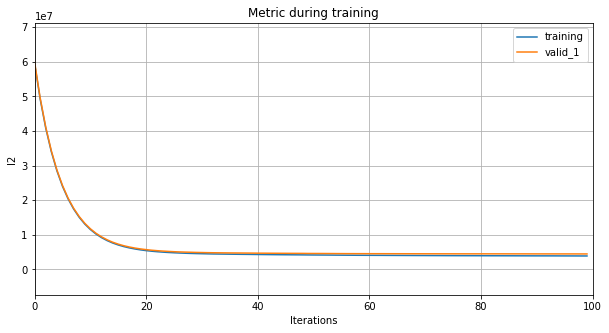

In [33]:
def render_metric(metric_name):
    ax = lgb.plot_metric(evals_result, metric=metric_name, figsize=(10, 5))
    plt.show()
render_metric(params['metric'])

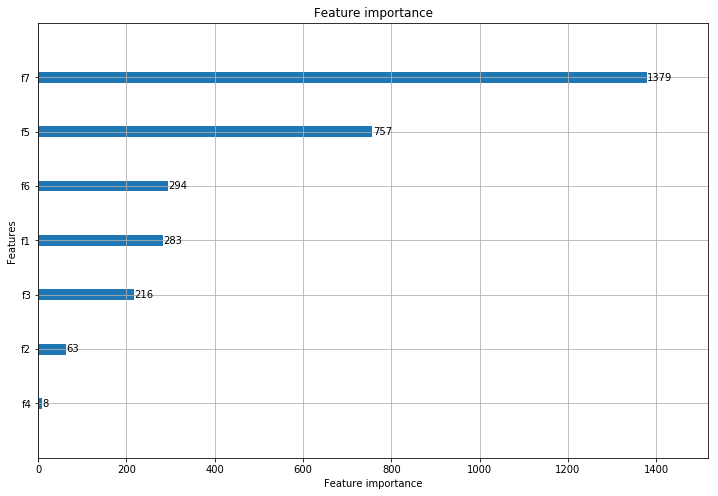

In [47]:
def render_plot_importance(importance_type, max_features=10,
                           ignore_zero=True, precision=4):
    ax = lgb.plot_importance(gbm, importance_type=importance_type,
                             max_num_features=max_features,
                             ignore_zero=ignore_zero, figsize=(12, 8),
                             precision=precision)
    plt.show()

render_plot_importance(importance_type='split')

In [45]:
from ipywidgets import interact, SelectMultiple
interact(render_plot_importance,
             importance_type=['split', 'gain'],
             max_features=(1, Xtrain.shape[-1]),
             precision=(0, 10))

interactive(children=(Dropdown(description='importance_type', options=('split', 'gain'), value='split'), IntSl…

<function __main__.render_plot_importance(importance_type, max_features=10, ignore_zero=True, precision=4)>

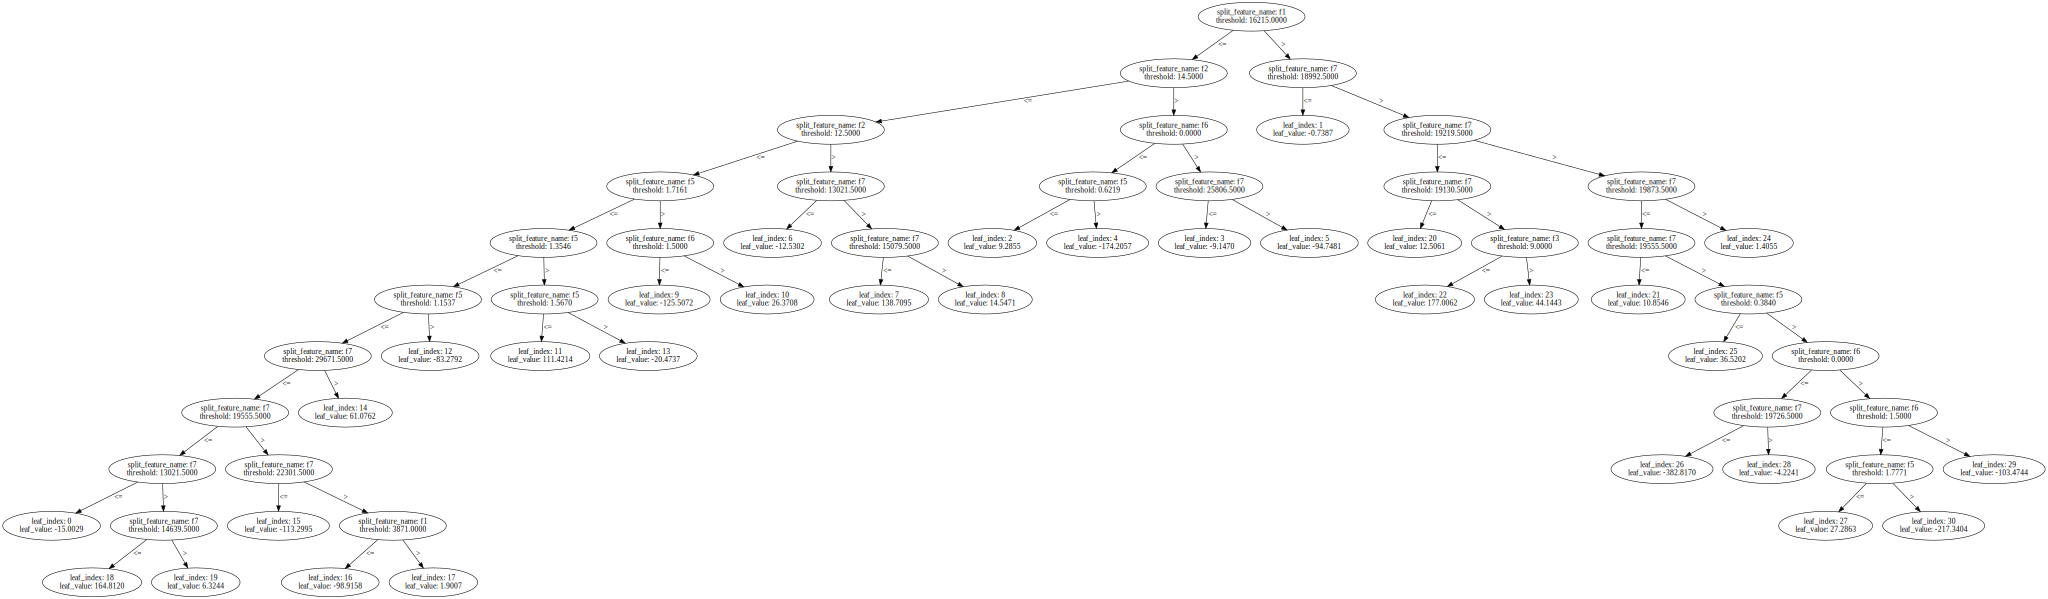

In [35]:
def render_tree(tree_index, show_info, precision=4):
    show_info = None if 'None' in show_info else show_info
    return lgb.create_tree_digraph(gbm, tree_index=tree_index,
                                   show_info=show_info, precision=precision)

tree = render_tree(84, ['None'])
tree

In [50]:
interact(render_tree,
             tree_index=(0, gbm.num_trees() - 1),
             show_info=SelectMultiple(  # allow multiple values to be selected
                 options=['None',
                          'split_gain',
                          'internal_value',
                          'internal_count',
                          'leaf_count'],
                 value=['None']),precision=(0, 10))
tree = None

interactive(children=(IntSlider(value=49, description='tree_index', max=99), SelectMultiple(description='show_…

In [36]:
#gbm = xgb.XGBClassifier(silent=1, max_depth=10, n_estimators=1000, learning_rate=0.05)
#gbm.fit(Xtrain, Ytrain)

Wanted to use XGBoost but takes too long to complete. 

## Validation time!

In [39]:
Ytest.head()

,eloc
75721,21292
80184,19326
19864,26192
76699,21462
92991,20865


In [55]:
pred = gbm.predict(Xtest)
pred = pred.astype(np.int)
#pred = pd.DataFrame({'eloc': pred})
#pred.head()

In [56]:
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(Ytest.values, pred) ** 0.5)

The rmse of prediction is: 2112.0202961264363


In [58]:
filterlabels = [-222, -145, 32950]
for x in filterlabels:
    ind = np.argwhere(pred == x)
    pred = np.delete(pred, ind)
print(le.inverse_transform(pred))

['wx4fz78' 'wx4ffw3' 'wx4g6rk' ... 'wx4eh48' 'wx4f9jj' 'wx4dw10']


## Remarks
The RMSE is very high which means that the feature needs future training and model tuned. 

Can ensemble: take the top 10 important feature from LightGBM to drive a second XGBoost model (Or more than one XGBoost models) to improve the accuracy. 